In [199]:
import getpass
import os

In [200]:
def set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide Key for {var}: ")
    else: 
        print("huiiii :)")

set_if_undefined("Groq_API_KEY")
set_if_undefined("TAVILY_API_KEY")

huiiii :)
huiiii :)


In [201]:
from typing import Annotated, List
from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_search = TavilySearch(max_results=5)

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [202]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"


In [203]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [204]:
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq
from langgraph.prebuilt import create_react_agent
import json

llm = ChatGroq(model="llama-3.3-70b-versatile")

search_agent = create_react_agent(llm, tools=[tavily_search])

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    print("[search_node] Input state:", state)
    print("[search_node] Result:", result)
    new_messages = [HumanMessage(content=result["messages"][-1].content, name="search")]
    # Try to extract URLs from ToolMessage if present
    for msg in result["messages"]:
        if hasattr(msg, "content") and "results" in msg.content:
            try:
                data = json.loads(msg.content)
                urls = [r["url"] for r in data.get("results", []) if "url" in r]
                if urls:
                    new_messages.append(HumanMessage(content=f"urls: {urls}", name="search_urls"))
            except Exception as e:
                print("Failed to parse URLs:", e)
    return Command(
        update={"messages": new_messages},
        goto="supervisor",
    )

web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    print("[web_scraper_node] Input state:", state)
    # Extract URLs from messages
    urls = []
    for msg in state.get("messages", []):
        if hasattr(msg, "content") and "urls:" in msg.content:
            import ast
            try:
                urls = ast.literal_eval(msg.content.split("urls:")[1].strip())
            except Exception as e:
                print("[web_scraper_node] Failed to parse URLs:", e)
    if not urls:
        print("[web_scraper_node] No URLs found in input. Scraper will not be called.")
        result_content = "No URLs provided for scraping."
    else:
        result_content = scrape_webpages(urls)
    print("[web_scraper_node] Result:", result_content)
    return Command(
        update={
            "messages": [HumanMessage(content=result_content, name="web_scraper")]
        },
        goto="supervisor",
    )

research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [205]:

research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()


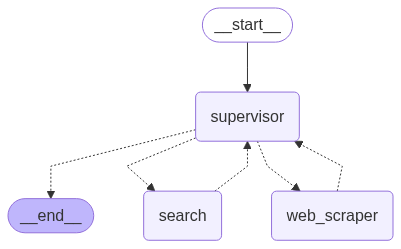

In [206]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in research_graph.stream(
    {"messages": [("user", "Whats the new update in indian GST Policy and rules?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

In [152]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [153]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

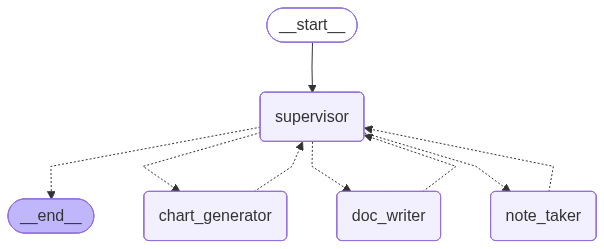

In [154]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    
    print("---")